# Cats and Dogs classification
Here we'll implement a simple Keras neural network to classify cats and dogs. The main idea here is learn keras and how to build simple convolutional networks 

references:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/@parthvadhadiya424/hello-world-program-in-keras-with-cnn-dog-vs-cat-classification-efc6f0da3cc5

### Importing LIbraries

In [80]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow import keras

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

## 1- Pre-processing Image
Here we'll capture and resize train images (around 9k images of cats and 9k of dogs)


### 1.1 - Get Dogs and Cats images
Here we'll get and resize dogs and cats images and mix those two in one bigger dataset. Also we'll create the classification vector

$$dog \rightarrow 1$$

$$cat \rightarrow 0$$

In [81]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH_DOG = './dataset/train/dog/'
TRAIN_PATH_CAT = './dataset/train/cat/'
TEST_PATH_DOG = './dataset/test/dog/'
TEST_PATH_CAT = './dataset/test/cat/'

In [82]:
# Get train and test IDs
train_ids_dog = next(os.walk(TRAIN_PATH_DOG))[2]
train_ids_cat = next(os.walk(TRAIN_PATH_CAT))[2]
test_ids_dog = next(os.walk(TEST_PATH_DOG))[2]
test_ids_cat = next(os.walk(TEST_PATH_CAT))[2]

In [83]:
# Get and resize dog train images
X_train_dog = np.zeros((len(train_ids_dog), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_dog = np.zeros((len(train_ids_dog), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids_dog), total=len(train_ids_dog)):
    path = TRAIN_PATH_DOG
    img = imread(path +id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_dog[n] = img
    Y_train_dog[n] = 1


Getting and resizing dog images ... 


100%|██████████| 9167/9167 [01:36<00:00, 95.32it/s] 


In [84]:
# Get and resize dog train images
X_train_cat = np.zeros((len(train_ids_cat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_cat = np.zeros((len(train_ids_cat), 1), dtype=np.uint8)

print('Getting and resizing cat images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids_cat), total=len(train_ids_cat)):
    path = TRAIN_PATH_CAT
    img = imread(path +id_ )[:,:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_cat[n] = img
    Y_train_cat[n] = 0

Getting and resizing cat images and masks ... 


100%|██████████| 9167/9167 [01:42<00:00, 89.04it/s] 


In [85]:
#print(X_train_dog[0].shape)

### 1.2 - Checking if everything is ok
X_train_dog should have a dog image with Y_train_dog = 1 the same for cat

[1]


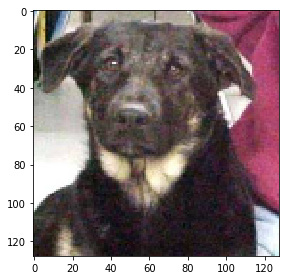

In [86]:
#for some dog image
ix = random.randint(0, len(X_train_dog))
imshow(X_train_dog[ix])
print(Y_train_dog[ix])

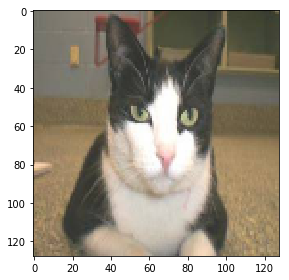

[0]


In [87]:
#for some cat image
ix = random.randint(0, len(X_train_cat))
imshow(X_train_cat[ix])
plt.show()
print(Y_train_cat[ix])

### 1.3 - Merging Cat and Dog train data and making train test slip
Now we'll merge datasets, verify if everything is how it should be.

After that we'll slip data in train and validation set and again verify the consistency

In [88]:
#Merging train dataset
X = np.concatenate((X_train_cat, X_train_dog))
y = np.concatenate((Y_train_cat, Y_train_dog))
print(X.shape, y.shape)

(18334, 128, 128, 3) (18334, 1)


/home/marcelostachuk/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


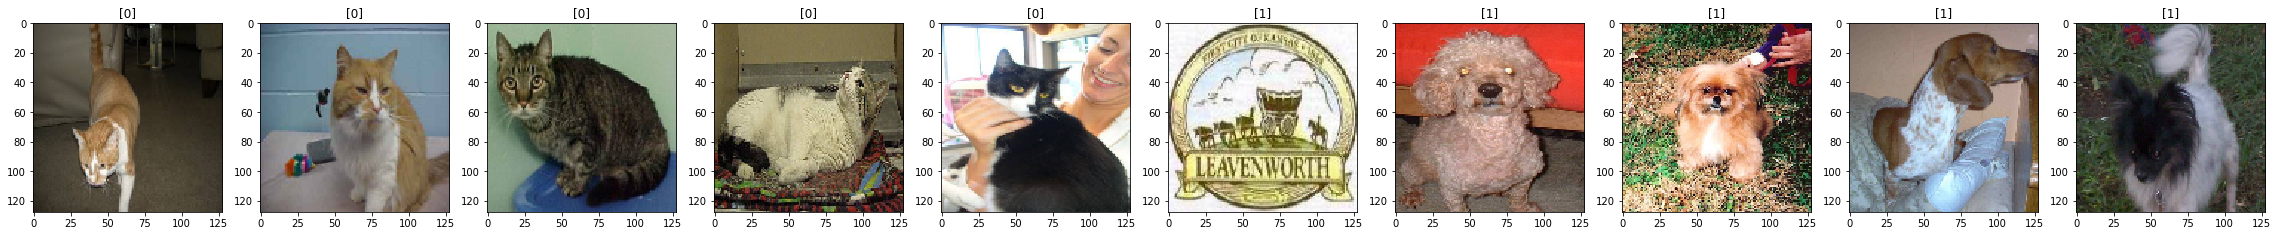

In [89]:
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X))
    ax[i].imshow(X[ix])
    ax[i].set_title(y[ix])

In [90]:
#Train test slip
from sklearn import model_selection

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

(14667, 128, 128, 3)


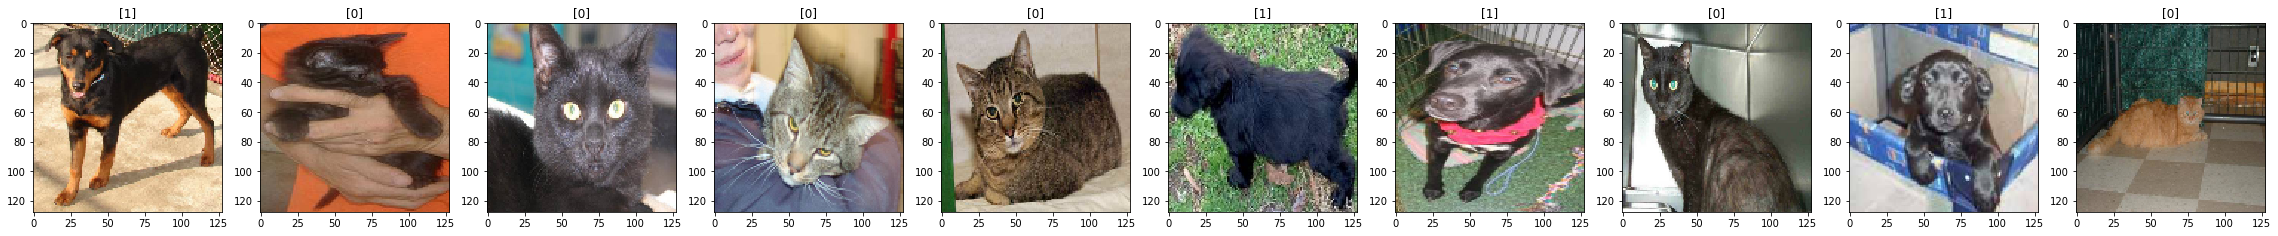

In [91]:
#Check train after split

print(X_train.shape)
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_train))
    ax[i].imshow(X_train[ix])
    ax[i].set_title(y_train[ix])

(3667, 128, 128, 3)


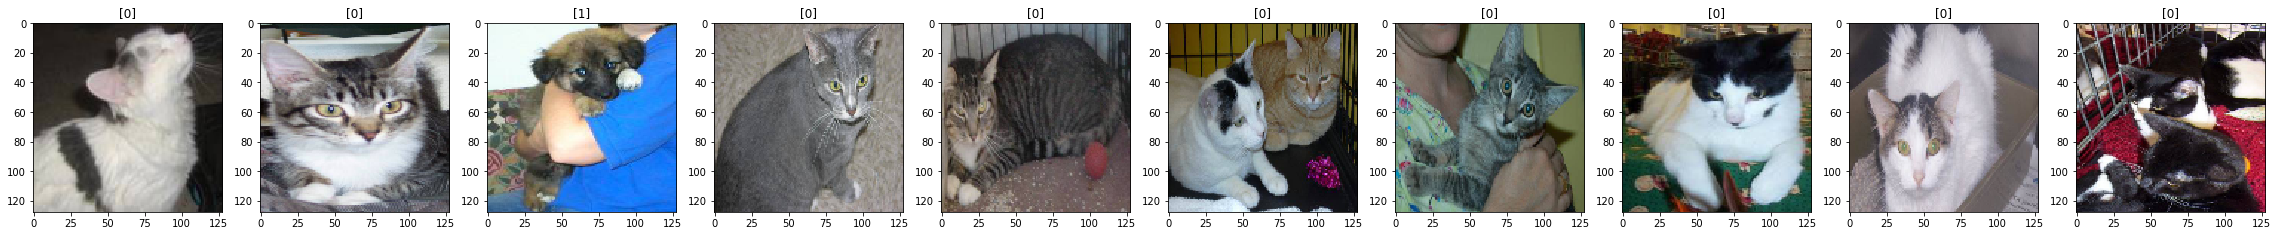

In [92]:
#Check val after split
print(X_val.shape)
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_val))
    ax[i].imshow(X_val[ix])
    ax[i].set_title(y_val[ix])

## 2 - Using simple neural network

### 2.1 - Creating convolutional neural network
Here we'll create a simple keras convolutional network.

First 3 convolutional layers (this is the convolutional part) after those layers pass it in one flatten layer and 2 fully connected layers



In [93]:
#Get inputs and normalize the pixels
inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = keras.layers.Lambda(lambda x: x / 255) (inputs)

#Convolutional part
c1 = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
p1 = keras.layers.MaxPooling2D(pool_size=(2,2))(c1)

c2 = keras.layers.Conv2D(32, (3,3), activation = 'relu')(p1)
p2 = keras.layers.MaxPooling2D(pool_size=(2,2))(c2)

c3 = keras.layers.Conv2D(64, (3,3), activation = 'relu')(p2)
p3 = keras.layers.MaxPooling2D(pool_size=(2,2))(c3)

# this converts our 3D feature maps to 1D feature vectors
f4 = keras.layers.Flatten()(p3)

#Dense part (Fully connected)
d5 = keras.layers.Dense(64, activation='relu')(f4)
d5 = keras.layers.Dropout(0.25)(d5)

outputs = keras.layers.Dense(1, activation='sigmoid')(d5)

#Compiling model
model = keras.Model(inputs = [inputs], outputs = outputs)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
__________

### 2.2 - Training
Now we'll train the network, saving the best model

In [95]:
#Save best model
checkpointer = keras.callbacks.ModelCheckpoint('model_second_try.h5', verbose=1, save_best_only=True)

#model = keras.models.load_model('model_first_try.h5')

#Train
results = model.fit(X_train, y_train, epochs=25, callbacks=[checkpointer], validation_data=(X_val, y_val))


Train on 14667 samples, validate on 3667 samples
Epoch 1/25
14667/14667 [==============================] - 46s 3ms/step - loss: 0.6281 - acc: 0.6212 - val_loss: 0.5773 - val_acc: 0.7109

Epoch 00001: val_loss improved from inf to 0.57733, saving model to model_second_try.h5
Epoch 2/25
14667/14667 [==============================] - 46s 3ms/step - loss: 0.5812 - acc: 0.6834 - val_loss: 0.5225 - val_acc: 0.7407

Epoch 00002: val_loss improved from 0.57733 to 0.52245, saving model to model_second_try.h5
Epoch 3/25
14667/14667 [==============================] - 46s 3ms/step - loss: 0.5332 - acc: 0.7266 - val_loss: 0.4860 - val_acc: 0.7707

Epoch 00003: val_loss improved from 0.52245 to 0.48603, saving model to model_second_try.h5
Epoch 4/25
14667/14667 [==============================] - 46s 3ms/step - loss: 0.4948 - acc: 0.7503 - val_loss: 0.4754 - val_acc: 0.7788

Epoch 00004: val_loss improved from 0.48603 to 0.47539, saving model to model_second_try.h5
Epoch 5/25
14667/14667 [===========

Note that overfitting is happening in the final epochs, since loss in training set is descreasing but val_loss in the validation set is increasing

### 2.3 - Preparation Test set
Here we'll follow the same steps as in train preparation. So the images will be resized and merged to one test dataset

In [96]:
# Get and resize dog test images
X_test_dog = np.zeros((len(test_ids_dog), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test_dog = np.zeros((len(test_ids_dog), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_dog), total=len(test_ids_dog)):
    path = TEST_PATH_DOG
    img = imread(path +id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_dog[n] = img
    Y_test_dog[n] = 1

Getting and resizing dog images ... 


100%|██████████| 3333/3333 [00:34<00:00, 96.73it/s] 


In [97]:
# Get and resize cat test images
X_test_cat = np.zeros((len(test_ids_cat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test_cat = np.zeros((len(test_ids_cat), 1), dtype=np.uint8)

print('Getting and resizing dog images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_cat), total=len(test_ids_cat)):
    path = TEST_PATH_CAT
    img = imread(path+id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_cat[n] = img
    Y_test_cat[n] = 0

Getting and resizing dog images ... 


100%|██████████| 3333/3333 [00:33<00:00, 98.37it/s] 


In [98]:
#Merging train dataset
X_test = np.concatenate((X_test_cat, X_test_dog))
y_test = np.concatenate((Y_test_cat, Y_test_dog))
print(X_test.shape, y_test.shape)

(6666, 128, 128, 3) (6666, 1)


(6666, 128, 128, 3)


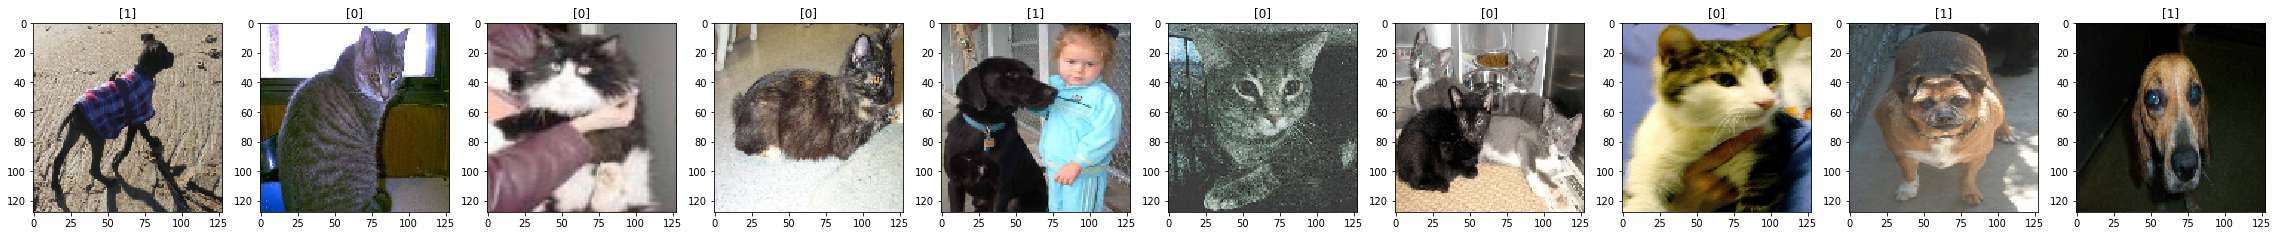

In [99]:
#Check train dataset
print(X_test.shape)
#Verificando consistencia
fig, ax = plt.subplots(1,10, figsize=(40,8))
for i in range(10):
    ix = random.randint(0, len(X_test))
    ax[i].imshow(X_test[ix])
    ax[i].set_title(y_test[ix])

### 2.4 - Testing
Now we'll use the test dataset to validate our model

First we'll predict the y and see the score and after that we'll see what we got wrong

In [101]:
#Load best model
final_model = keras.models.load_model('./model_second_try.h5')

In [102]:
#Predict y from our test set
y_test_pred = final_model.predict(X_test)

In [103]:
#Function to calculate the score
def score(y_pred, y_true):
    score = 0
    for i in range(len(y_true)):
        score += np.abs(np.round(y_pred[i])-y_true[i])
    return 1-score/len(y_test)

print(score(y_test_pred, y_test))

[0.8019802]


Olhando os cachorros e gatos pior classificados

In [104]:
#Probably not the best method

#Return a dict with which dog we've got wrong and how much wrong it was
def dogs_wrong(y_pred, y_true):
    dic_where_value = {}
    for i in range(len(y_true)):
        #if is a dog and get wrong
        if (y_true[i] == 1 and np.abs(np.round(y_pred[i])-y_true[i]) != 0):
            #dict[which_dog] = how_wrong
            dic_where_value[i] = y_pred[i]
    return dic_where_value

#Return how many dogs we've got wrong
def how_many_dogs_wrongs(y_pred, y_true):
    return len(dogs_wrong(y_pred, y_true))

#Return the top n wrong dogs
def top_n_wrong_dogs(n, y_pred, y_true):
    dict_wrongs = dogs_wrong(y_pred, y_true)
    if (len(dict_wrongs) <= n):
        return list(dict_wrongs.keys()), list(dict_wrongs.values())
    else:
        all_values = np.sort(np.array(list(dict_wrongs.values())), axis=None)
        #print(all_values.shape)
        top_n_values = all_values[:n]
        #print(top_n_values)
        list_keys = []
        list_values = []
        for i in list(dict_wrongs.keys()):
            if (dict_wrongs[i] in top_n_values):
                list_keys.append(i)
                list_values.append(dict_wrongs[i])
    return list_keys, list_values

#Print top n wrong dogs
def print_n_wrong_dogs(n, X_print, y_pred, y_true):
    list_keys, list_values = top_n_wrong_dogs(n, y_pred, y_true)
    fig, ax = plt.subplots(1,n, figsize=(40,8))
    for i in range(n):
        ax[i].imshow(X_print[list_keys[i]])
        ax[i].set_title(str(list_values[i]))
    

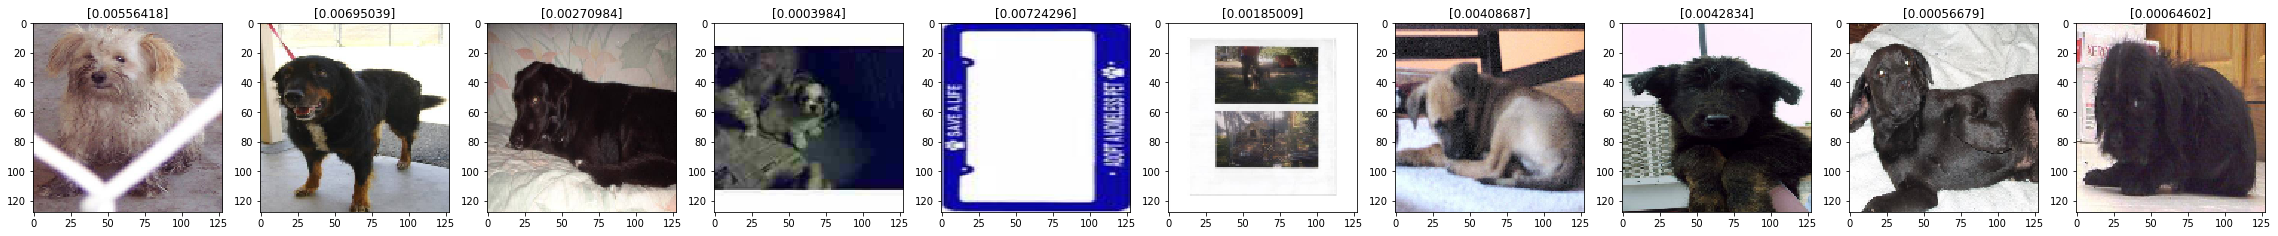

In [105]:
#Lets see it
print_n_wrong_dogs(10, X_test, y_test_pred, y_test)

In [106]:
#Return a dict with which dog we've got wrong and how much wrong it was
def cats_wrong(y_pred, y_true):
    dic_where_value = {}
    for i in range(len(y_true)):
        #if is a cat and get wrong
        if (y_true[i] == 0 and np.abs(np.round(y_pred[i])-y_true[i]) != 0):
            dic_where_value[i] = y_pred[i]
    return dic_where_value

#Return how many cats we've got wrong
def how_many_cats_wrongs(y_pred, y_true):
    return len(cats_wrong(y_pred, y_true))

#Return the top n wrong cats
def top_n_wrong_cats(n, y_pred, y_true):
    dict_wrongs = cats_wrong(y_pred, y_true)
    if (len(dict_wrongs) <= n):
        return list(dict_wrongs.keys()), list(dict_wrongs.values())
    else:
        all_values = np.sort(np.array(list(dict_wrongs.values())), axis=None)
        #print(all_values.shape)
        top_n_values = all_values[-n:]
        #print(top_n_values)
        list_keys = []
        list_values = []
        for i in list(dict_wrongs.keys()):
            if (dict_wrongs[i] in top_n_values):
                list_keys.append(i)
                list_values.append(dict_wrongs[i])
    return list_keys, list_values

#Print top n wrong cats
def print_n_wrong_cats(n, X_print, y_pred, y_true):
    list_keys, list_values = top_n_wrong_cats(n, y_pred, y_true)
    fig, ax = plt.subplots(1,n, figsize=(40,8))
    for i in range(n):
        ax[i].imshow(X_print[list_keys[i]])
        ax[i].set_title(str(list_values[i]))
    

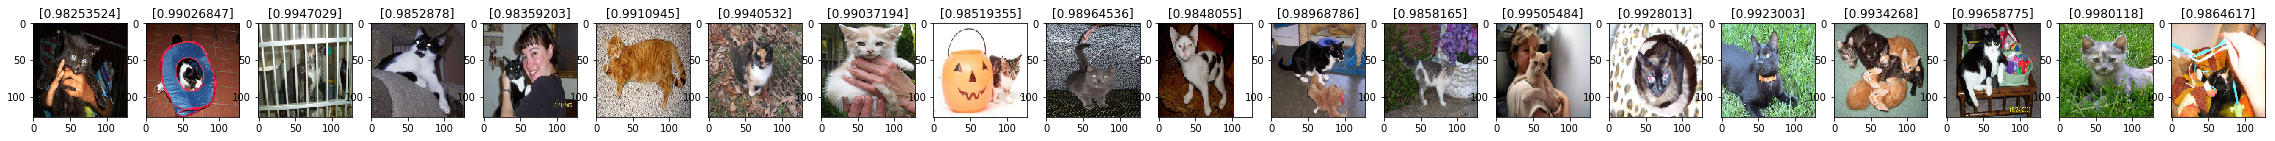

In [107]:
#And lets see it
print_n_wrong_cats(20, X_test, y_test_pred, y_test)

## 3 - Using pre-treined network
First we'll use the VGG imagenet to extract features from our train dataset on top that we'll create a fully connected network to make classification

### 3.1 - Importing VGG and extracting features

In [59]:
#Import VGG net
model_vgg = keras.applications.VGG16(include_top=False, weights='imagenet')

#Extracting features
bottleneck_features_train = model_vgg.predict(x = X_train)
bottleneck_features_validation = model_vgg.predict(x = X_val)

In [206]:
#Saving those features
np.save('bottleneck_features_train.npy', bottleneck_features_train)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [60]:
#bottleneck_features_train.shape[1:]

### 3.2 - Fully conected on top of vgg

In [61]:
#Import features extracted from VGG
train_data = np.load('bottleneck_features_train.npy')
validation_data = np.load('bottleneck_features_validation.npy')

#Creating one fully connected network on top of VGG
inputs_pre = keras.Input(shape = train_data.shape[1:])

#Flatten layer
f1_pre = keras.layers.Flatten()(inputs_pre)

#Dense layers
d1_pre = keras.layers.Dense(256, activation='relu')(f1_pre)

d2_pre = keras.layers.Dense(64, activation='relu')(d1_pre)
d2_pre = keras.layers.Dropout(0.25)(d2_pre)

outputs = keras.layers.Dense(1, activation='sigmoid')(d2_pre)

model_pre = keras.Model(inputs = [inputs_pre], outputs = outputs)
model_pre.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 2,113,921
Trainable params: 2,113,921
Non-trainable params: 0
_________________________________________________________________


### 3.3 - Training and saving model

In [62]:
#Save best model
checkpointer_pre = keras.callbacks.ModelCheckpoint('model_first_try_pre.h5', verbose=1, save_best_only=True)

#model = keras.models.load_model('model_first_try.h5')
b
#Training model
results_pre = model_pre.fit(train_data, y_train, epochs=25, callbacks=[checkpointer_pre], 
                            validation_data=(validation_data, y_val))

Train on 14667 samples, validate on 3667 samples
Epoch 1/25
14667/14667 [==============================] - 10s 667us/step - loss: 0.7646 - acc: 0.8835 - val_loss: 0.2315 - val_acc: 0.9215

Epoch 00001: val_loss improved from inf to 0.23150, saving model to model_first_try_pre.h5
Epoch 2/25
14667/14667 [==============================] - 7s 470us/step - loss: 0.1689 - acc: 0.9410 - val_loss: 0.2145 - val_acc: 0.9299

Epoch 00002: val_loss improved from 0.23150 to 0.21446, saving model to model_first_try_pre.h5
Epoch 3/25
14667/14667 [==============================] - 7s 468us/step - loss: 0.0920 - acc: 0.9665 - val_loss: 0.2288 - val_acc: 0.9318

Epoch 00003: val_loss did not improve from 0.21446
Epoch 4/25
14667/14667 [==============================] - 7s 487us/step - loss: 0.0551 - acc: 0.9799 - val_loss: 0.2164 - val_acc: 0.9381

Epoch 00004: val_loss did not improve from 0.21446
Epoch 5/25
14667/14667 [==============================] - 7s 462us/step - loss: 0.0398 - acc: 0.9858 - val

### 3.4 - Testing it
We'll load the model and prepare out test set to enter in our model. For this we must pass it through VGG to extract features

In [68]:
#Loading model
final_model_pre = keras.models.load_model('model_first_try_pre.h5')

In [69]:
#Preparing test set 
model_vgg = keras.applications.VGG16(include_top=False, weights='imagenet')
bottleneck_features_test = model_vgg.predict(x = X_test)

In [71]:
#Watching score
y_test_pred_pre = final_model_pre.predict(bottleneck_features_test)
print(score(y_test_pred_pre, y_test))

[0.92844284]


288


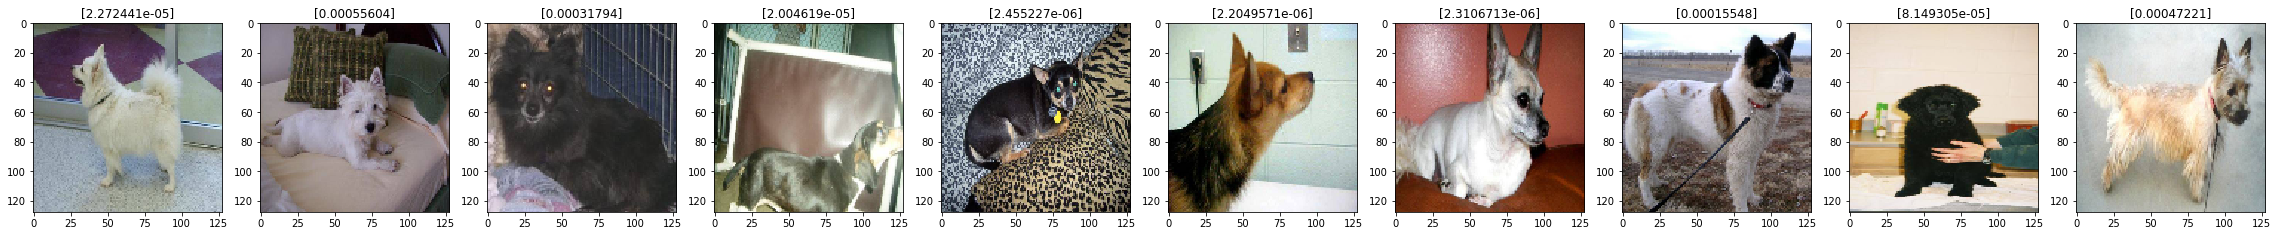

In [75]:
#How we did in dogs
print(how_many_dogs_wrongs(y_test_pred_pre, y_test))
print_n_wrong_dogs(10, X_test, y_test_pred_pre, y_test)

189


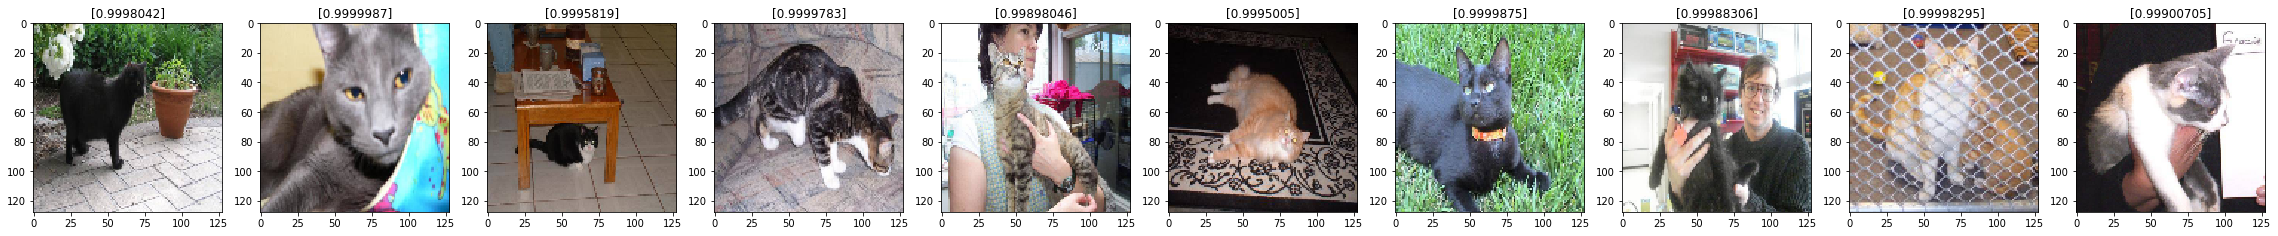

In [76]:
print(how_many_cats_wrongs(y_test_pred_pre, y_test))
print_n_wrong_cats(10, X_test, y_test_pred_pre, y_test)